In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
import copy
import requests
from urllib.parse import urlparse

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
def get_photo(url):
  response = requests.get(url)
  parsed_url = urlparse(url)
  filename = parsed_url.path.split('/')[-1]
  with open(filename, 'wb') as f:
      f.write(response.content)

In [4]:
get_photo("https://raw.githubusercontent.com/allseenn/transfer/main/02.Tasks/img/cat1.jpg")
get_photo("https://raw.githubusercontent.com/allseenn/transfer/main/02.Tasks/img/cat2.jpg")
get_photo("https://raw.githubusercontent.com/allseenn/transfer/main/02.Tasks/img/picaso.jpg")
get_photo("https://raw.githubusercontent.com/allseenn/transfer/main/02.Tasks/img/vangogh.jpg")

In [5]:
cat1 = Image.open("cat1.jpg")
cat2 = Image.open("cat2.jpg")
picaso = Image.open("picaso.jpg")
vangogh = Image.open("vangogh.jpg")

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
cat1_tensor = transform(Image.open("cat1.jpg")).unsqueeze(0)
cat2_tensor = transform(Image.open("cat2.jpg")).unsqueeze(0)
picaso_tensor = transform(Image.open("picaso.jpg")).unsqueeze(0)
vangogh_tensor = transform(Image.open("vangogh.jpg")).unsqueeze(0)
cat1_tensor.size()

torch.Size([1, 3, 512, 512])

In [7]:
content1 = cat1_tensor.to(device, torch.float)
content2 = cat2_tensor.to(device, torch.float)
style1 = picaso_tensor.to(device, torch.float)
style2 = vangogh_tensor.to(device, torch.float)
style2.shape

torch.Size([1, 3, 512, 512])

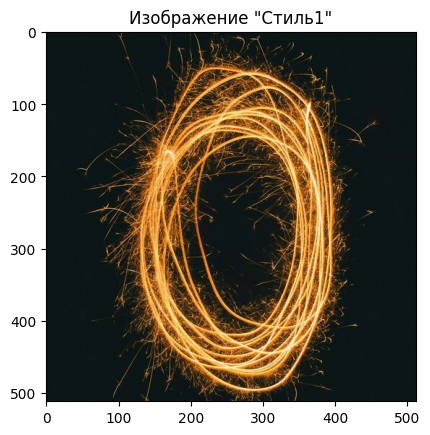

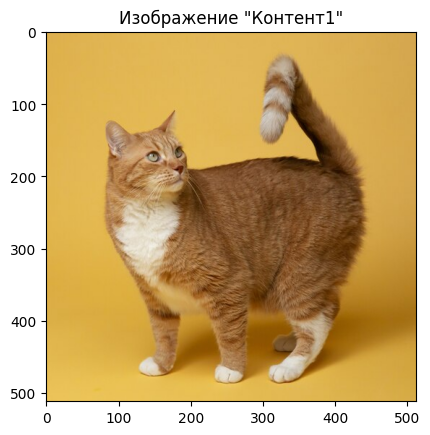

In [8]:
unloader = transforms.ToPILImage()  # Преобразуем в картинку PIL

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # создаем копию тензора чтобы не менять исходный
    image = image.squeeze(0)      # устраняем лишнее измерение (которое делало батч из изображения)
    image = unloader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Дадим графику обновиться
plt.figure()
imshow(style1, title='Изображение "Стиль1"')

plt.figure()
imshow(content1, title='Изображение "Контент1"')

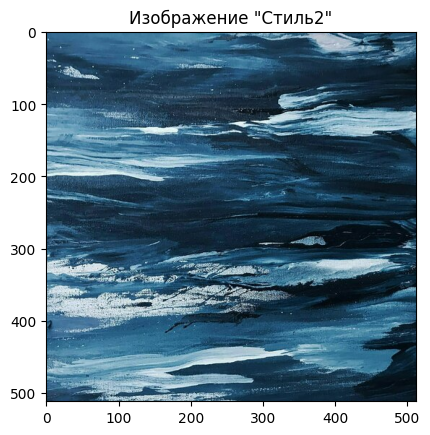

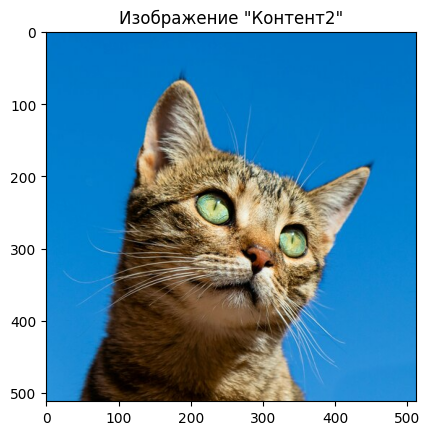

In [9]:
plt.figure()
imshow(style2, title='Изображение "Стиль2"')

plt.figure()
imshow(content2, title='Изображение "Контент2"')

In [10]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # нуно "отвязать" (detach) набор целевых признаков (target content)
        # от других объектов, которые находят его градиент. Это статический объект
        # Если этого не сделать, метод forward вернут нам ошибку
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [11]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=размер батча(=1)
    # b=количество карт признаков, для которых мы считаем матрицу
    # (c,d)=размерность карты признаков f (N=c*d)

    features = input.view(a * b, c * d)  # изменим размерность матрицы F_XL, получим \hat F_XL

    G = torch.mm(features, features.t())  # рассчитать произведение матриц чтобы получить матрицу Грама

    # нормализуем значения матрицы Грама, разделив значения матрицы на количество элементов
    return G.div(a * b * c * d)

In [12]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [13]:
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 54.9MB/s]


In [14]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# упаковочный класс, чтобы картинку было легче передать в объект ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # преобразуем мат.ожидание и дисперсию при помощи .view так, чтобы
        # их можно было легко умножить на тензор с картинкой
        # Картинка имеет размерность [B x C x H x W]
        # Мы приводим коэффициенты нормализации к размерности [C x 1 x 1]
        # B – размер батча. C – количество каналов. H – высота, W – ширина изображения.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # нормализуем изображение ``img``
        return (img - self.mean) / self.std

In [15]:
# названия слоев, где мы будем рассчитывать расхождение по контенту
content_layers_default = ['pool_4']

# названия слоев, где мы будем рассчитывать расхождение по стилю
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # модуль чтобы нормализоавть изображения
    normalization = Normalization(normalization_mean, normalization_std)

    # будем складывать меры расхождения (лоссы) в удобные массивы
    content_losses = []
    style_losses = []

    # поскольку ``cnn`` является объектом типа ``nn.Sequential``,
    # создадим новый ``nn.Sequential`` куда мы по порядку положим
    # все модули, которые будут проводить вычисления в нейросети
    model = nn.Sequential(normalization)

    i = 0  # пройдемся по элементам в исходной нейросети и дадим им имена
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # Чуть изменим параметры слоев активации (версия которая использована
            # в исходной нейросети не работает с нашей реализацией ``ContentLoss`` и ``StyleLoss``)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # Добавим очередной модуль в нашу Sequential-модель
        model.add_module(name, layer)

        if name in content_layers:
            # если к последнему слою нужно пристыковать контент-лосс, сделаем это
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # а если имя слоя в списке стиль-лоссов, добавим после него соответствующий лосс
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # все слои которые идут после последнего добавленного контент-лосса или стиль-лосса
    # нам будут не нужны, их можно отбросить
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

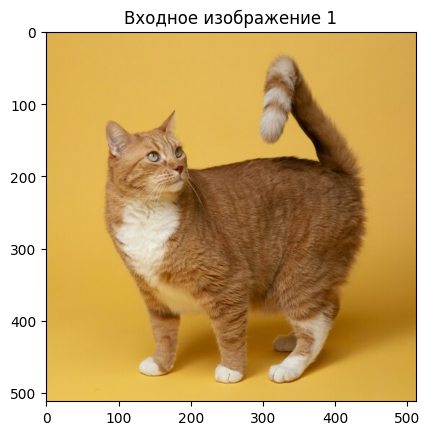

In [16]:
input_img1 = content1.clone()
plt.figure()
imshow(input_img1, title='Входное изображение 1')

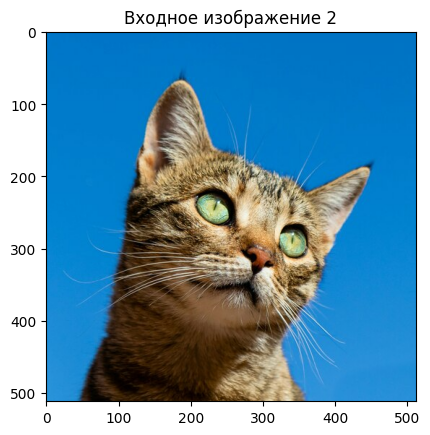

In [17]:
input_img2 = content2.clone()
plt.figure()
imshow(input_img2, title='Входное изображение 2')

In [18]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100, content_weight=100):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # Укажем, какой объект мы будем оптимизировать (включить параметр requires_grad fields)
    input_img.requires_grad_(True)
    # Переключим модель в режим исполнения, чтобы заморозить слои вроде dropout или батч нормализации normalization layers
    model.eval()
    # Очевидно, мы не будем оптимизировать модель, так что заморозим все параметры
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # скорректируем значения входного изображения
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad() # обнуляем градиенты (иногда их используют между итерациями, но не сейчас)
            model(input_img) # знакомая вам функция, отправить картинку в модель

            # Посчитаем расхождение изображений по стилю и содержимому
            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight # Домножаем каждую компоненту лосса на заданный вес
            content_score *= content_weight

            loss = style_score + content_score
            # И по этому значению осуществляем обратное распространение ошибки (обратно по сети, вплоть до изображения)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # и в последний раз вернем изображение в диапазон
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Построение модели переноса стиля..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Оптимизируем картинку..
run [50]:
Style Loss : 1.737762 Content Loss: 4.082489

run [100]:
Style Loss : 1.458714 Content Loss: 4.186765

run [150]:
Style Loss : 2.171037 Content Loss: 5.898055

run [200]:
Style Loss : 3.214958 Content Loss: 6.916845

run [250]:
Style Loss : 1.883604 Content Loss: 7.318340

run [300]:
Style Loss : 3.388639 Content Loss: 5.676042



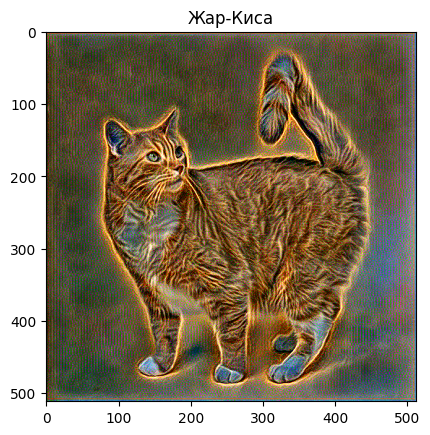

In [20]:
output1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content1, style1, input_img1, style_weight=1000, content_weight=1)

plt.figure()
imshow(output1, title='Жар-Киса')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 7.266415 Content Loss: 8.385138

run [100]:
Style Loss : 2.957439 Content Loss: 7.112482

run [150]:
Style Loss : 1.650098 Content Loss: 6.346976

run [200]:
Style Loss : 1.003900 Content Loss: 5.799951

run [250]:
Style Loss : 1.331801 Content Loss: 6.088832

run [300]:
Style Loss : 0.657122 Content Loss: 5.155483



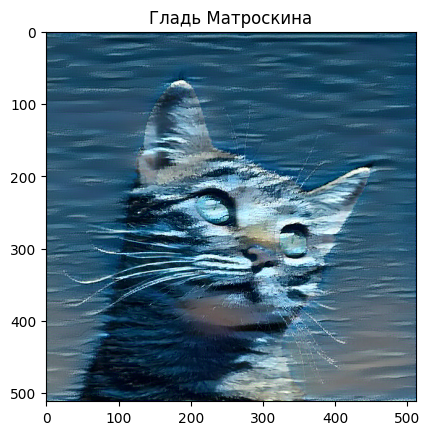

In [21]:
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content2, style2, input_img2, style_weight=100000, content_weight=1)

plt.figure()
imshow(output2, title='Гладь Матроскина')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()